In [1]:

import pandas as pd
import numpy as np
from unidecode import unidecode
from libpysal.weights.contiguity import Queen
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#df_f0=pd.read_excel("Bases//Base_Limpia.xlsx")

from scipy.stats import pearsonr, chi2_contingency

df_f=pd.read_csv("Bases//Base_Limpia_Added.csv")

In [2]:
df=df_f.copy()
df_aux=df_f.copy()


In [3]:
# Convert 'fecha' and 'fecha_fin_trat' to datetime
df_aux['fecha'] = pd.to_datetime(df_aux['fecha'])
df_aux['fecha_fin_trat'] = pd.to_datetime(df_aux['fecha_fin_trat'])

# Create a date range covering all weeks from the earliest start to the latest end date
weekly_dates = pd.date_range(start=df_aux['fecha'].min(), end=df_aux['fecha_fin_trat'].max(), freq='W')

# Create columns for each week and province with the number of active cases
for week_start in weekly_dates:
    week_end = week_start + pd.Timedelta(days=6)
    week_label = week_start.strftime("%Y-%m-%d")
    
    df_aux[week_label] = ((df_aux['fecha'] <= week_end) & (df_aux['fecha_fin_trat'] >= week_start)).astype(int)

# Group by province and department, summing the active cases for each week
df_casos_activos_depto = pd.DataFrame(df_aux.groupby(['provincia', 'departamento'])[weekly_dates.strftime('%Y-%m-%d')].sum().to_records())

# Select specific weekly columns for further analysis
selected_weeks = list(df_casos_activos_depto.columns[200:213])
df_casos_activos_depto_fecha = df_casos_activos_depto[['provincia', 'departamento'] + selected_weeks]


In [4]:
import geopandas as gpd
from utils import utils

# Load the shapefile using geopandas
ruta_archivo_shp = 'Bases\\Vecindad\\Codgeo_Pais_x_dpto_con_datos\\pxdptodatosok.shp'
dataframe_shp = gpd.read_file(ruta_archivo_shp)

# Clean province and department names
dataframe_shp["provincia"] = dataframe_shp["provincia"].apply(utils.quitar_acentos_limpiar).str.replace("Ciudad Autonoma de Buenos Aires", "Caba")
dataframe_shp["departamen"] = dataframe_shp["departamen"].apply(utils.quitar_acentos_limpiar)

# Copy and clean department data
df_deptos = df_f.copy()
df_deptos.loc[(df_deptos["departamento"] == "Desconocido") | (df_deptos["departamento"] == "Nan"), "departamento"] = np.nan
df_deptos = df_deptos.loc[(~df_deptos["departamento"].isnull()) & (df_deptos["departamento"] != "")]
df_deptos["departamento"] = df_deptos["departamento"].str.replace("Gral manuel belgrano", "Dr. manuel belgrano")
df_deptos["AUX"] = 1

# Display unique department names
df_deptos["departamento"].unique()


array(['ALMIRANTE BROWN', 'BAHIA BLANCA', 'BERAZATEGUI', 'EZEIZA',
       'FLORENCIO VARELA', 'GENERAL PUEYRREDON', 'LA MATANZA', 'LA PLATA',
       'MERLO', 'Comuna 15', 'Comuna 10', 'Comuna 7', 'Comuna 9',
       'COMANDANTE FERNANDEZ', 'CAPITAL', 'RIO CUARTO', 'FORMOSA',
       'GRAL MANUEL BELGRANO', 'OBERA', 'SAN IGNACIO',
       'GENERAL SAN MARTIN', '9 DE JULIO', 'LA CAPITAL', 'ROSARIO',
       'LEALES', 'ESTEBAN ECHEVERRIA', 'LOMAS DE ZAMORA',
       'MALVINAS ARGENTINAS', 'QUILMES', 'ZARATE', 'Comuna 4',
       'GENERAL GUEMES', 'PATINO', 'RAMON LISTA', 'ANTA', 'CERRILLOS',
       'LA CALDERA', 'METAN', 'RIVADAVIA', 'JUAN MARTIN DE PUEYRREDON',
       'AVELLANEDA', 'HURLINGHAM', 'ITUZAINGO', 'JOSE C PAZ', 'LANUS',
       'SAN MIGUEL', 'SAN FERNANDO', 'MARCOS JUAREZ', 'BERMEJO',
       'MATACOS', 'CONSTITUCION', 'FAMAILLA', 'ORAN', 'GENERAL OBLIGADO',
       'MORENO', 'MORON', 'VILLARINO', 'PARANA', 'IGUAZU',
       'SAN CRISTOBAL', 'CRUZ ALTA', 'FEDERACION', 'PIRANE',
       '

In [5]:
# Create a pivot table to count infections by province and department
df_aux = pd.pivot_table(df_deptos, index=["provincia", "departamento"], values="AUX", aggfunc="sum")
df_aux2 = pd.DataFrame(df_aux.to_records())
df_aux2.columns = ["provincia", "departamen", "Infecciones"]

# Load the shapefile using geopandas
ruta_archivo_shp = 'Bases\\Vecindad\\Codgeo_Pais_x_dpto_con_datos\\pxdptodatosok.shp'
dataframe_shp = gpd.read_file(ruta_archivo_shp)

# Clean province names
dataframe_shp["provincia"] = dataframe_shp["provincia"].apply(utils.quitar_acentos_limpiar).str.replace("Ciudad Autonoma de Buenos Aires", "Caba")

# Create a pivot table to count cases by link
cases_dept = pd.DataFrame(pd.pivot_table(df_f, index=["link"], values="id", aggfunc="count").to_records())

# Convert 'link' to string for both dataframes
dataframe_shp["link"] = dataframe_shp["link"].astype(int).astype(str)
cases_dept["link"] = cases_dept["link"].astype(str)

# Merge shapefile data with case counts
cases_dept_area = pd.merge(dataframe_shp, cases_dept, on=["link"], how="right")
cases_dept_area = cases_dept_area.rename(columns={"id": "infecciones"})
cases_dept_area = cases_dept_area[~cases_dept_area["provincia"].isnull()]


In [7]:
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import libpysal
import esda
import numpy as np
import matplotlib.pyplot as plt

def autocorrelacion_plot(df_prov, solo_mapa=0):
    """
    Plots the spatial autocorrelation of infection data using Moran's I and LISA.

    Args:
    df_prov (GeoDataFrame): Geospatial data containing infection counts.
    solo_mapa (int): If 1, only the LISA cluster map is displayed.

    Returns:
    GeoDataFrame: Updated with LISA results.
    """
    y = df_prov['infecciones'].values
    w = libpysal.weights.Queen.from_dataframe(df_prov)
    lisa = Moran_Local(y, w)

    # Add LISA results to the GeoDataFrame
    df_prov['lisa_I'] = lisa.Is
    df_prov['lisa_p'] = lisa.p_sim
    df_prov['lisa_cluster'] = lisa.q
    df_prov['HH'] = np.where((df_prov['lisa_cluster'] == 1) & (df_prov['lisa_p'] <= 0.05), 1, 0)

    if solo_mapa == 0:
        # Plot Moran scatterplot
        fig, ax = moran_scatterplot(lisa)
        ax.set_xlabel('Infecciones')
        ax.set_ylabel('Spatial Lag of Infecciones')
        plt.savefig('Documentacion\\figures\\morgan_scatter_grey.png', dpi=300)
        plt.show()

        fig, ax = moran_scatterplot(lisa, p=0.05)
        ax.set_xlabel('Infecciones')
        ax.set_ylabel('Spatial Lag of Infecciones')
        plt.savefig('Documentacion\\figures\\morgan_scatter.png', dpi=300)

        plt.show()

    # Show LISA clusters on the map
    lisa_cluster(lisa, df_prov, p=0.05, figsize=(9, 9))
    plt.savefig('Documentacion\\figures\\lisa.png', dpi=300)
    plt.show()

    if solo_mapa == 0:
        # Plot local autocorrelation
        plot_local_autocorrelation(lisa, df_prov, 'infecciones')
        plt.show()

    # Find the department with the highest LISA I value
    max_infections = lisa.Is.max()
    department_with_max_infections = df_prov.loc[df_prov['lisa_I'] == max_infections]

    print("Department with the highest infections:")
    print(department_with_max_infections)

    # Subset for departments with more than 10 infections
    df_prov_subset = df_prov[df_prov['infecciones'] > 10]
    y = df_prov_subset['infecciones'].values
    w = libpysal.weights.Queen.from_dataframe(df_prov_subset)
    moran_loc = Moran_Local(y, w)

    # Add Moran Local results to the DataFrame
    df_prov_subset['moran_Is'] = moran_loc.Is
    df_prov_subset['moran_p_sim'] = moran_loc.p_sim
    df_prov_subset['moran_q'] = moran_loc.q





In [8]:
df_casos_activos_depto_fecha2 = df_casos_activos_depto_fecha.copy()

# Segment the analysis by date
ANALISIS_FECHA = False
if ANALISIS_FECHA:
    col_fechas = df_casos_activos_depto_fecha2.columns
    l_fechas = len(col_fechas)
    for i in range(2, l_fechas):
        # Print the current date column
        print(col_fechas[i])
        
        # Subset data for the current date
        df_fecha = df_casos_activos_depto_fecha2[["provincia", "departamento", col_fechas[i]]]
        df_fecha.columns = ["provincia", "departamen", "infecciones"]
        
        # Merge with shapefile data
        df_mexclado3 = pd.merge(dataframe_shp, df_fecha, on=["provincia", "departamen"], how="left")
        
        # Filter out rows with unknown or irrelevant provinces
        df_mexclado3 = df_mexclado3.loc[(df_mexclado3["provincia"] != "Desconocida") & (df_mexclado3["provincia"] != 'Tierra del Fuego')]

        # Select relevant columns for spatial analysis
        df_aux_vecindad = df_mexclado3.loc[(~df_mexclado3["codpcia"].isnull())][["departamen", "infecciones", "geometry"]]
        df_aux_vecindad = df_aux_vecindad.fillna(0)
        
        # Generate spatial autocorrelation plot
        autocorrelacion_plot(df_aux_vecindad, solo_mapa=1)


In [9]:
# Flag to control whether it should run for each provinc
ANALISIS_TOP = False
if ANALISIS_TOP:
    for t in cases_dept_area["provincia"].unique():
        if t != "Desconocida" and t != "Tierra del Fuego":
            # Standardize province name
            t = unidecode(str(t))
            print(t)
            
            # Subset data for the current province
            df_aux_vecindad = cases_dept_area.loc[(cases_dept_area["provincia"] == t) & (~cases_dept_area["codpcia"].isnull())].reset_index(drop=True)[["departamen", "infecciones", "geometry"]]

            # Generate spatial autocorrelation plot
            autocorrelacion_plot(df_aux_vecindad, solo_mapa=1)


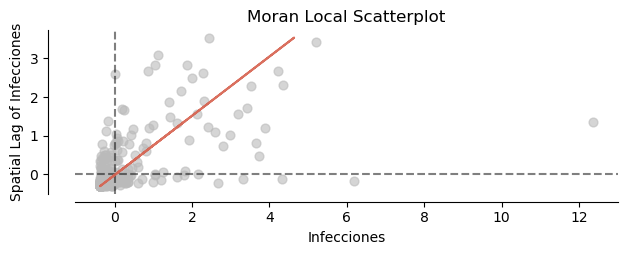

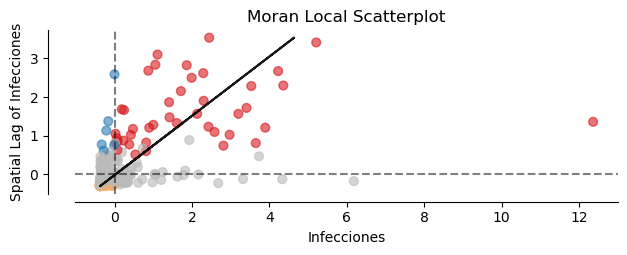

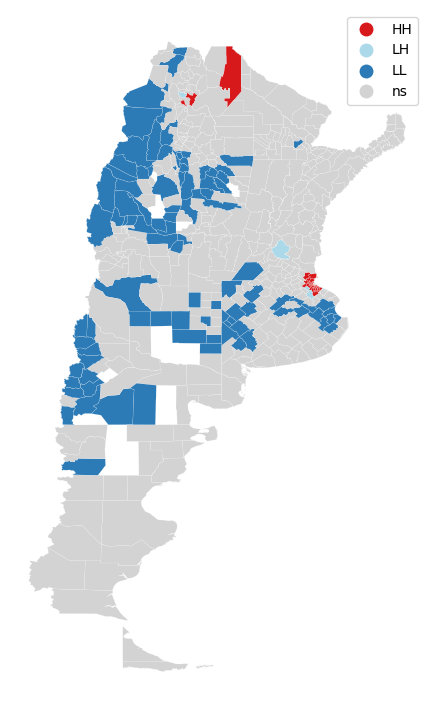

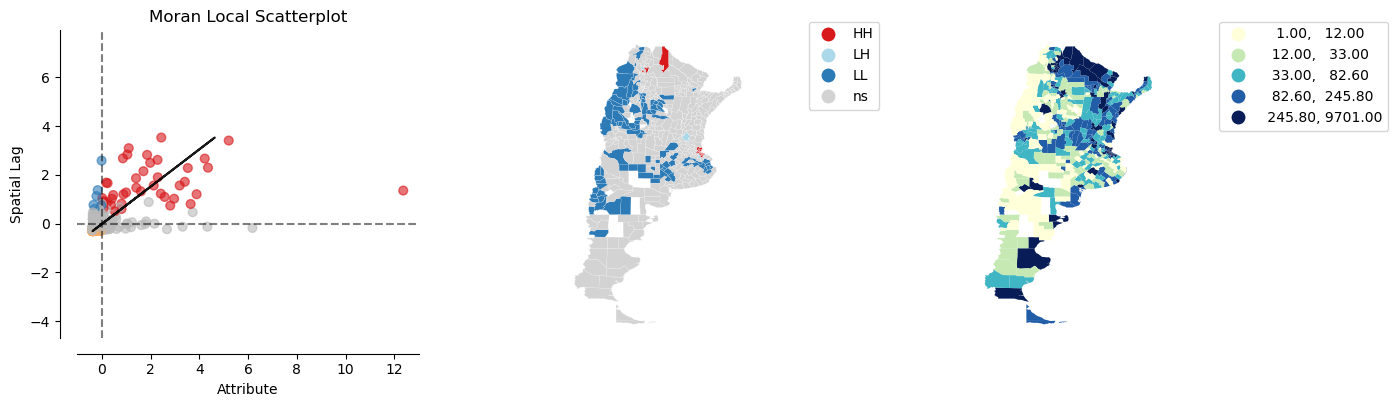

Department with the highest infections:
       provincia       departamen  infecciones  \
88  Buenos Aires  Lomas de Zamora         4255   

                                             geometry     lisa_I  lisa_p  \
88  POLYGON ((-58.46128 -34.70617, -58.46116 -34.7...  23.255784   0.001   

    lisa_cluster  HH  
88             1   1  
('WARNING: ', 316, ' is an island (no neighbors)')
('WARNING: ', 416, ' is an island (no neighbors)')


In [10]:
# Sort cases by the number of infections in descending order
cases_dept_area2 = cases_dept_area.sort_values(by=["infecciones"], ascending=False)

# Perform spatial autocorrelation analysis on the sorted data
df_lisa = autocorrelacion_plot(cases_dept_area2[["provincia", "departamen", "infecciones", "geometry"]])


In [11]:
cases_dept_area2

,link,codpcia,departamen,provincia,mujeres,varones,personas,hogares,viv_part,viv_part_h,geometry,infecciones
79,6427,06,La Matanza,Buenos Aires,909126,866690,1775816,484909,447306,405338,"POLYGON ((-58.52885 -34.65516, -58.52847 -34.6...",9701
459,82084,82,Rosario,Santa Fe,622099,571506,1193605,392533,434485,354507,"POLYGON ((-60.69614 -32.83999, -60.69611 -32.8...",4995
88,6490,06,Lomas de Zamora,Buenos Aires,319237,297042,616279,188844,188186,167304,"POLYGON ((-58.46128 -34.70617, -58.46116 -34.7...",4255
115,6658,06,Quilmes,Buenos Aires,301015,281928,582943,177110,182216,163717,"POLYGON ((-58.33361 -34.72800, -58.33303 -34.7...",3608
393,66028,66,Capital,Salta,279283,256830,536113,137000,136697,119603,"POLYGON ((-65.58015 -24.65886, -65.57784 -24.6...",3587
...,...,...,...,...,...,...,...,...,...,...,...,...
375,58084,58,Ñorquín,Neuquen,2209,2483,4692,1380,1964,1267,"POLYGON ((-70.69090 -37.34155, -70.68801 -37.3...",1
300,42049,42,Chalileo,La Pampa,1443,1542,2985,947,1191,900,"POLYGON ((-66.02058 -36.00134, -66.02290 -36.0...",1
246,26056,26,Languiñeo,Chubut,1377,1708,3085,1073,1337,957,"POLYGON ((-70.28985 -42.65335, -70.28952 -42.6...",1
174,14070,14,Minas,Cordoba,2294,2433,4727,1495,2105,1447,"POLYGON ((-64.90352 -31.27947, -64.92635 -31.2...",1


In [12]:
df_lisa.sort_values(by="infecciones",ascending=False)[:30][["provincia","departamen","infecciones","lisa_I","lisa_p","lisa_cluster","HH"]]

AttributeError: 'NoneType' object has no attribute 'sort_values'